# 1. CLEAN AND COMBINE DATA SOURCES

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import utils
import data_cleaning

### a. Disinfo and Infodemic Data
Disinfo: https://github.com/gtziafas/nlp4ifchallenge/tree/main/data/english

Infodemic: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XYK2UE

In [22]:
disinfo = data_cleaning.clean_disinfo('../data/covid19_disinfo/covid19_disinfo_binary_english_train_old.tsv')
infodemic = data_cleaning.clean_infodemic('../data/covid19_infordemic/covid19_infodemic_english_data.tsv')
disinfodemic = disinfo.append(infodemic).drop_duplicates()
utils.check_tweet_len(disinfodemic)
utils.check_tweet_len(disinfodemic, labels=['q2_label'])

                  len_tweet                                              \
                      count        mean        std   min     25%    50%   
q2_label q4_label                                                         
0        0            465.0  212.387097  54.662450  38.0  178.00  230.0   
         1            136.0  219.970588  51.759120  73.0  188.75  235.5   
1        0             23.0  115.173913  75.166876  47.0   58.00   90.0   
         1             30.0  205.133333  63.004506  54.0  181.00  229.0   

                                  
                      75%    max  
q2_label q4_label                 
0        0         257.00  292.0  
         1         260.25  293.0  
1        0         149.00  269.0  
         1         254.25  273.0  
         len_tweet                                                         
             count        mean        std   min    25%    50%    75%    max
q2_label                                                                   
0

In [18]:
disinfo['q2_label'].value_counts()

0    457
1     39
Name: q2_label, dtype: int64

In [19]:
infodemic['q2_label'].value_counts()

0    221
1     37
Name: q2_label, dtype: int64

### b. Cassie and Linh's manual labelling

In [23]:
manual_labeled_data = data_cleaning.clean_manual_data()
utils.check_tweet_len(manual_labeled_data)
utils.check_tweet_len(manual_labeled_data, labels=['q2_label'])

                  len_tweet                                               \
                      count        mean         std    min    25%    50%   
q2_label q4_label                                                          
0        0             82.0  208.804878   56.159262   72.0  168.0  227.0   
         1              3.0  161.333333  107.584076   83.0  100.0  117.0   
1        0              1.0  199.000000         NaN  199.0  199.0  199.0   
         1             46.0  197.500000   68.263786   54.0  156.0  204.5   

                                  
                      75%    max  
q2_label q4_label                 
0        0         256.75  291.0  
         1         200.50  284.0  
1        0         199.00  199.0  
         1         257.00  290.0  
         len_tweet                                                         
             count        mean        std   min    25%    50%    75%    max
q2_label                                                              

### c. COVID19 Fake News Detection in English

A Heuristic-driven Ensemble Framework for COVID-19 Fake News Detection: https://github.com/diptamath/covid_fake_news/tree/main/data

In [4]:
constraint = data_cleaning.clean_constraint_competition('../data/CONSTRAINT_competition/Constraint_Train.csv')
utils.check_tweet_len(constraint, labels=['q2_label'])

         len_tweet                                                           
             count        mean         std   min    25%    50%    75%     max
q2_label                                                                     
0           3360.0  187.619940   60.271544  25.0  133.0  196.0  241.0   293.0
1           3060.0  133.196405  191.576544  17.0   78.0  110.5  161.0  8570.0


### d. Cross-SEAN: A cross-stitch semi-supervised neural attention model for COVID-19 fake news detection

https://github.com/williamscott701/Cross-SEAN

In [5]:
cross_sean = data_cleaning.clean_cross_sean(file='../data/Cross_SEAN/train.txt')
utils.check_tweet_len(cross_sean, labels=['q2_label'])

         len_tweet                                                       
             count        mean        std  min   25%    50%    75%    max
q2_label                                                                 
0          11000.0  140.890909  68.709788  4.0  85.0  129.0  203.0  283.0
1          11000.0  123.090636  63.538579  6.0  77.0  113.0  149.0  299.0


# 2. Q2 Investigation

## I. Establishing baselines

### a. Using only data from Disinfo and Infodemic papers

In [6]:
X_train_a, X_test_a, y_train_a, y_test_a = utils.prepare_data(disinfodemic['tidy_tweet'], disinfodemic['q2_label'], test_size=0.4)
X_train_a, X_test_a = utils.words_embedding(X_train_a, X_test_a, model='sentence_transformer')

In [28]:
X_train, X_test, y_train, y_test = X_train_a, X_test_a, y_train_a, y_test_a
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       241
           1       0.15      0.38      0.22        21

    accuracy                           0.78       262
   macro avg       0.54      0.60      0.54       262
weighted avg       0.87      0.78      0.82       262

Train

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       360
           1       0.36      0.91      0.52        32

    accuracy                           0.86       392
   macro avg       0.68      0.88      0.72       392
weighted avg       0.94      0.86      0.89       392



Linh's comments for Cassie: 

- I just tried the most basic baseline set up here and the results were not good and weird. I think the data is just so imbalanced: i.e., so few positive samples in this dataset (Disinfo + Infodemic datasets). Thus, going forward in the notebook, I'll try to add more datasets from other sources. 
- I wanted to try to run the codes in the original Infodemic paper but the codes are more complicated than I thought. I will still try to run them later though when I have more time. Maybe we can generate better baseline results using their models. Also, I'm slightly confused how they calculate their F1-scores given that the data is so imbalanced, thus we can investigate more when we look into their codes.

### b. Adding Cassie and Linh's manual label

In [8]:
X_train_b, X_test_b, y_train_b, y_test_b = utils.prepare_data(manual_labeled_data['tidy_tweet'], 
                                                        manual_labeled_data['q2_label'], test_size=0.2)
X_train_b, X_test_b = utils.words_embedding(X_train_b, X_test_b, model='sentence_transformer')

In [30]:
X_train, X_test, y_train, y_test = X_train_b, X_test_b, y_train_b, y_test_b
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.64      0.70      0.67        10

    accuracy                           0.74        27
   macro avg       0.72      0.73      0.73        27
weighted avg       0.75      0.74      0.74        27

Train

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        68
           1       0.89      0.92      0.91        37

    accuracy                           0.93       105
   macro avg       0.92      0.93      0.93       105
weighted avg       0.93      0.93      0.93       105



In [32]:
X_train, X_test, y_train, y_test = np.concatenate((X_train_a, X_train_b, X_test_b)), X_test_a, \
                                   np.concatenate((y_train_a, y_train_b, y_test_b)), y_test_a
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       241
           1       0.20      0.43      0.28        21

    accuracy                           0.82       262
   macro avg       0.57      0.64      0.59       262
weighted avg       0.89      0.82      0.85       262

Train

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       445
           1       0.50      0.87      0.64        79

    accuracy                           0.85       524
   macro avg       0.74      0.86      0.77       524
weighted avg       0.90      0.85      0.87       524



Linh's comments for Cassie: Adding our manual labeled data did not seem to help much.

### c. Add CONSTRAINT Competition data
https://github.com/diptamath/covid_fake_news/tree/main/data

In [11]:
X_train_c, X_test_c, y_train_c, y_test_c = utils.prepare_data(constraint['tidy_tweet'], 
                                                        constraint['q2_label'], test_size=0.2)
X_train_c, X_test_c = utils.words_embedding(X_train_c, X_test_c, model='sentence_transformer')

In [33]:
X_train, X_test, y_train, y_test = X_train_c, X_test_c, y_train_c, y_test_c
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       672
           1       0.90      0.91      0.91       612

    accuracy                           0.91      1284
   macro avg       0.91      0.91      0.91      1284
weighted avg       0.91      0.91      0.91      1284

Train

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2688
           1       0.92      0.92      0.92      2448

    accuracy                           0.92      5136
   macro avg       0.92      0.92      0.92      5136
weighted avg       0.92      0.92      0.92      5136



In [34]:
X_train, X_test, y_train, y_test = np.concatenate((X_train_a, X_train_b, X_test_b, X_train_c, X_test_c)), X_test_a, \
                                   np.concatenate((y_train_a, y_train_b, y_test_b, y_train_c, y_test_c)), y_test_a
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.97      0.51      0.67       241
           1       0.13      0.81      0.22        21

    accuracy                           0.54       262
   macro avg       0.55      0.66      0.45       262
weighted avg       0.90      0.54      0.64       262

Train

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3805
           1       0.87      0.89      0.88      3139

    accuracy                           0.89      6944
   macro avg       0.89      0.89      0.89      6944
weighted avg       0.89      0.89      0.89      6944



### d. Add Cross-SEAN data

https://github.com/williamscott701/Cross-SEAN

In [14]:
X_train_d, X_test_d, y_train_d, y_test_d = utils.prepare_data(cross_sean['tidy_tweet'], 
                                                        cross_sean['q2_label'], test_size=0.2)
X_train_d, X_test_d = utils.words_embedding(X_train_d, X_test_d, model='sentence_transformer')

In [35]:
X_train, X_test, y_train, y_test = X_train_d, X_test_d, y_train_d, y_test_d
utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2200
           1       0.95      0.95      0.95      2200

    accuracy                           0.95      4400
   macro avg       0.95      0.95      0.95      4400
weighted avg       0.95      0.95      0.95      4400

Train

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      8800
           1       0.95      0.96      0.95      8800

    accuracy                           0.95     17600
   macro avg       0.95      0.95      0.95     17600
weighted avg       0.95      0.95      0.95     17600



In [135]:
X_train, X_test, y_train, y_test = np.concatenate((X_train_a, X_train_b, X_test_b, X_train_c, X_test_c, X_train_d, X_test_d)), \
                                   X_test_a, \
                                   np.concatenate((y_train_a, y_train_b, y_test_b, y_train_c, y_test_c, y_train_d, y_test_d)), \
                                   y_test_a

utils.logit_model(X_train, X_test, y_train, y_test)

Test

              precision    recall  f1-score   support

           0       0.96      0.55      0.70       241
           1       0.12      0.71      0.21        21

    accuracy                           0.56       262
   macro avg       0.54      0.63      0.45       262
weighted avg       0.89      0.56      0.66       262

Train

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     14805
           1       0.90      0.90      0.90     14139

    accuracy                           0.90     28944
   macro avg       0.90      0.90      0.90     28944
weighted avg       0.90      0.90      0.90     28944



## II. EDA some more

In [161]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

pca_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3, whiten=True))

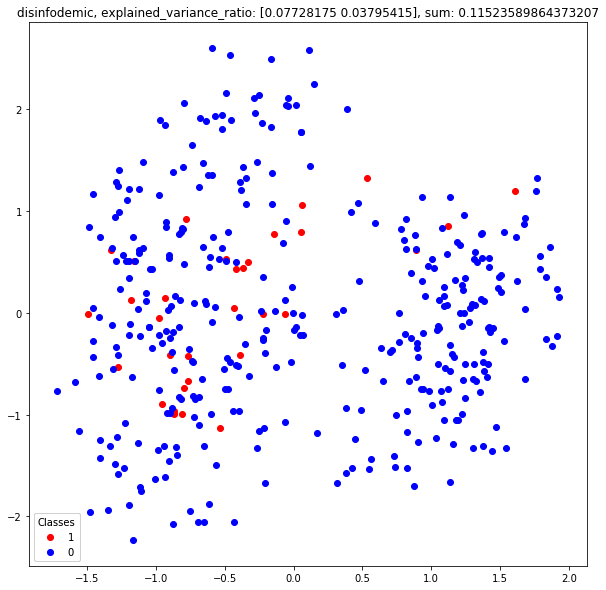

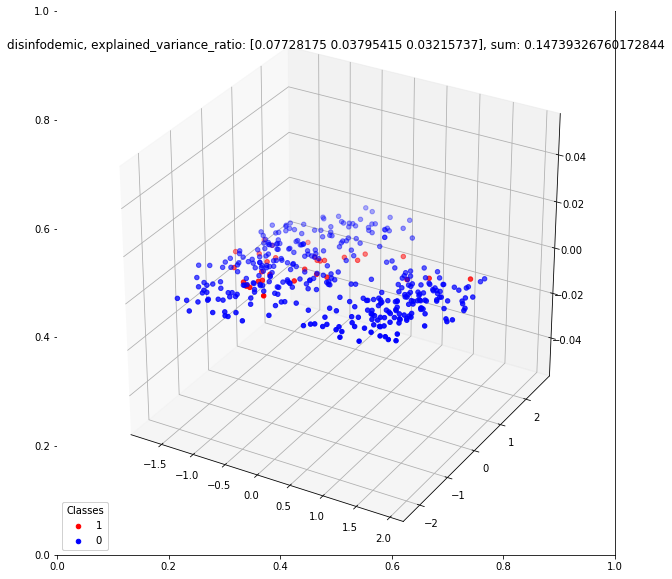

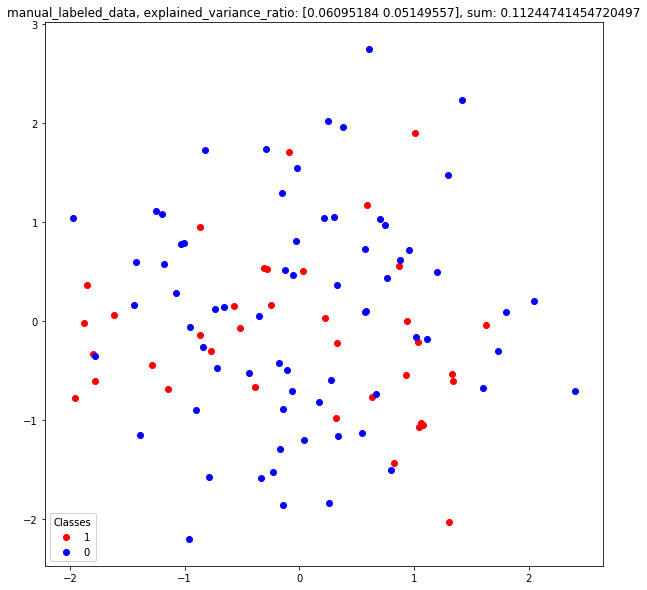

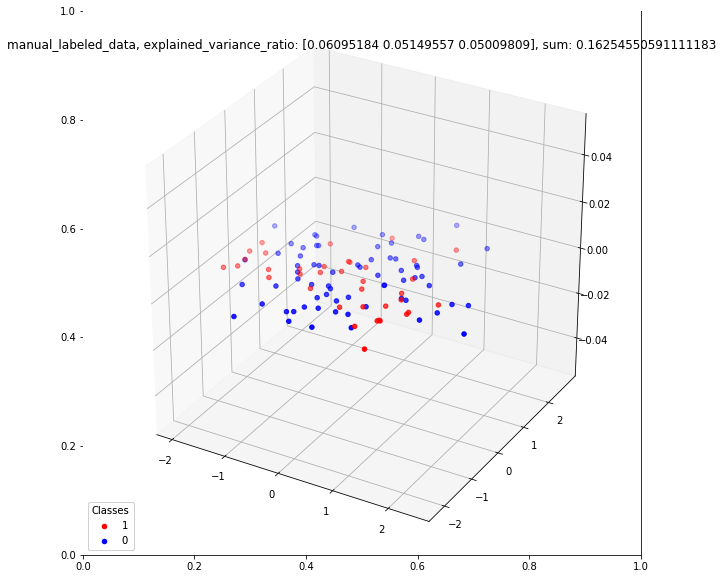

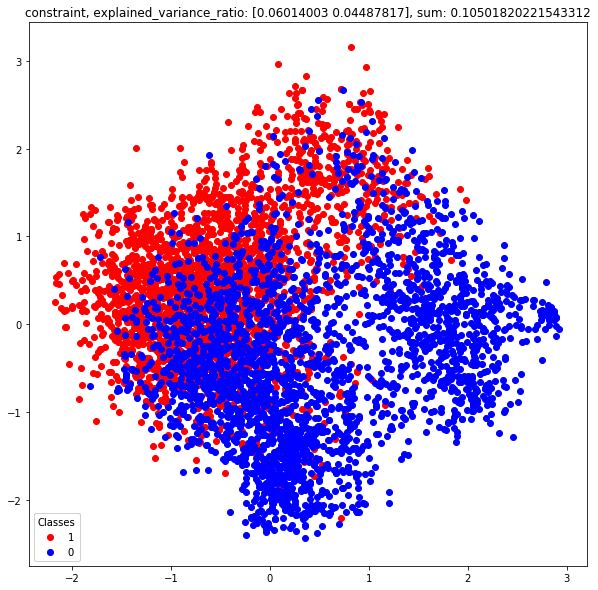

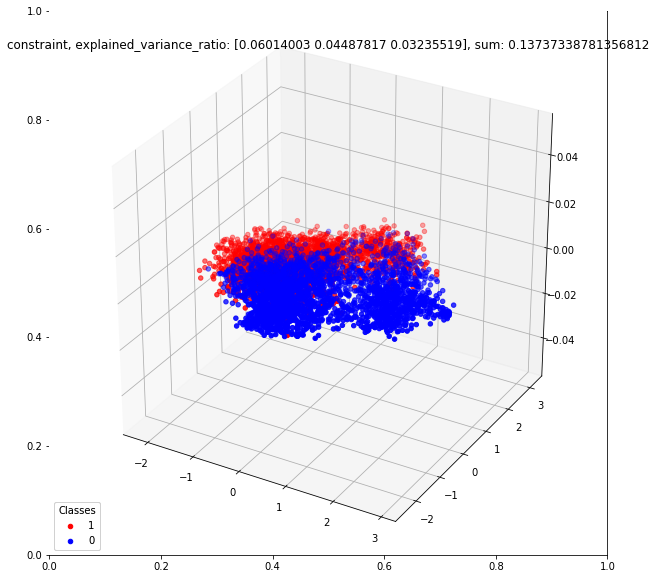

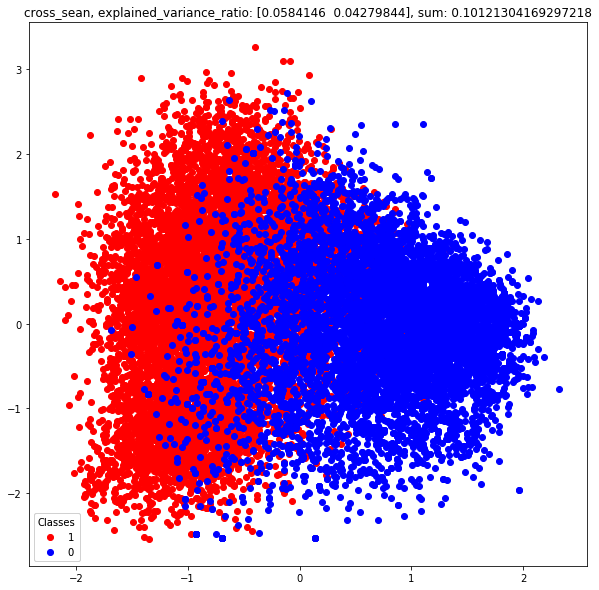

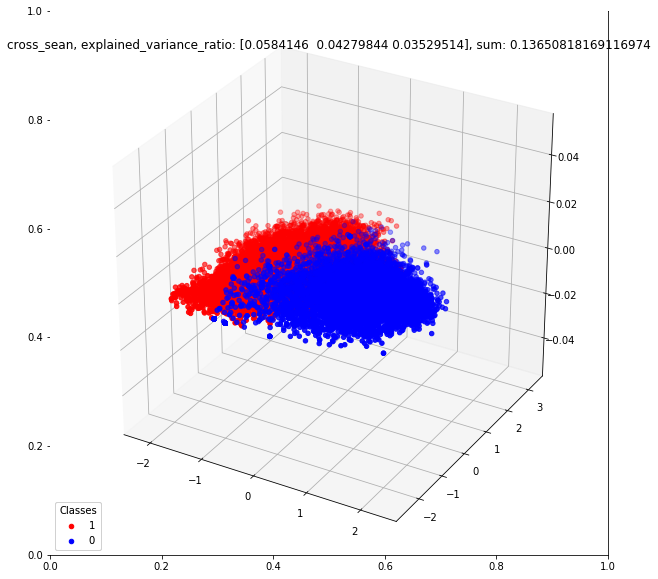

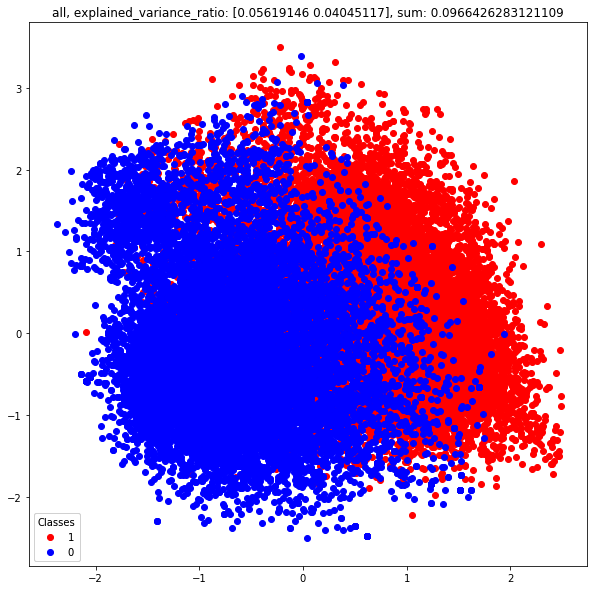

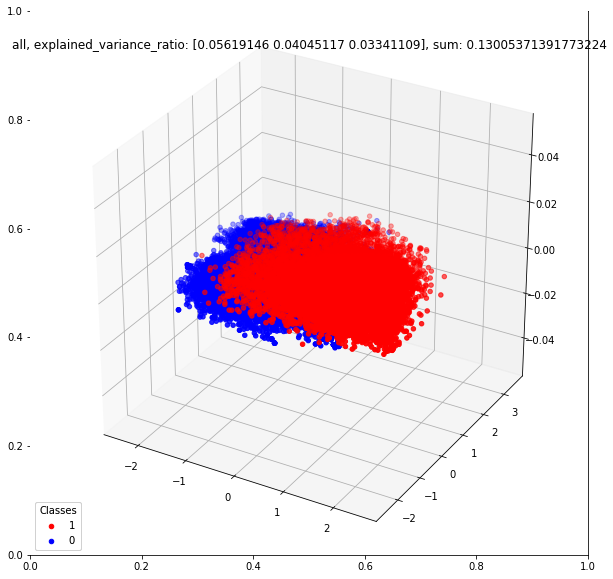

In [170]:
data_dict = {'disinfodemic': [X_train_a, y_train_a],
             'manual_labeled_data': [X_train_b, y_train_b],
             'constraint': [X_train_c, y_train_c],
             'cross_sean': [X_train_d, y_train_d],
             'all': [X_train, y_train]}

for data in data_dict:
    X_reduced = pca_pipeline.fit_transform(data_dict[data][0])
    pca = pca_pipeline.named_steps["pca"]
    utils.visualize_2pcs(X_reduced, data_dict[data][1], title=data+", explained_variance_ratio: "+str(pca.explained_variance_ratio_[:2])+", sum: "+str(sum(pca.explained_variance_ratio_[:2])))
    utils.visualize_3pcs(X_reduced, data_dict[data][1], title=data+", explained_variance_ratio: "+str(pca.explained_variance_ratio_[:3])+", sum: "+str(sum(pca.explained_variance_ratio_[:3])))

In [171]:
groups = np.array(['1. infodemic']*len(y_train_a)+['2. manual']*len(y_train_b)+['2. manual']*len(y_test_b)+['3. constraint']*len(y_train_c)+['3. constraint']*len(y_test_c)+['4. cross_sean']*len(y_train_d)+['4. cross_sean']*len(y_test_d))

pca.explained_variance_ratio_: [0.05619152 0.04045112 0.03341106] sum: 0.13005370274186134


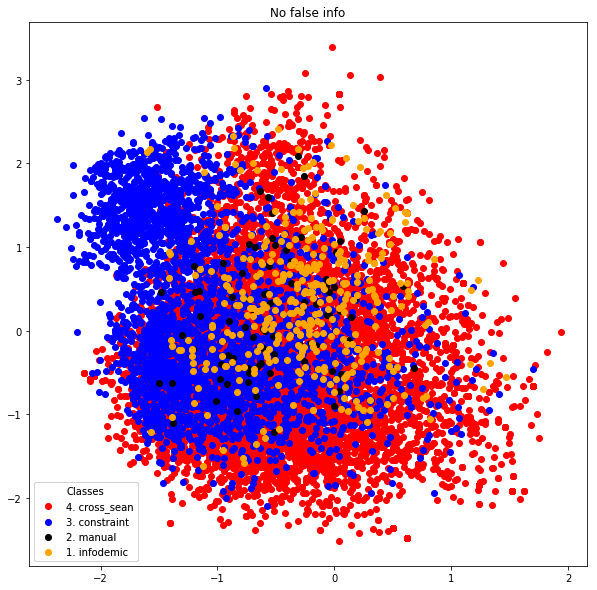

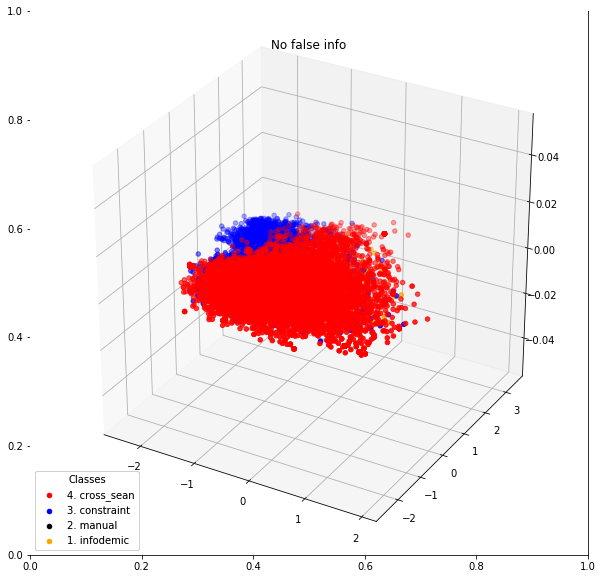

In [172]:
X_reduced = pca_pipeline.fit_transform(X_train)
pca = pca_pipeline.named_steps["pca"]
print("pca.explained_variance_ratio_:", pca.explained_variance_ratio_, "sum:", sum(pca.explained_variance_ratio_))
utils.visualize_2pcs(X_reduced[y_train==0], groups[y_train==0], title='No false info')
utils.visualize_3pcs(X_reduced[y_train==0], groups[y_train==0], title='No false info')

pca.explained_variance_ratio_: [0.0561915  0.04045115 0.03341104] sum: 0.13005368411540985


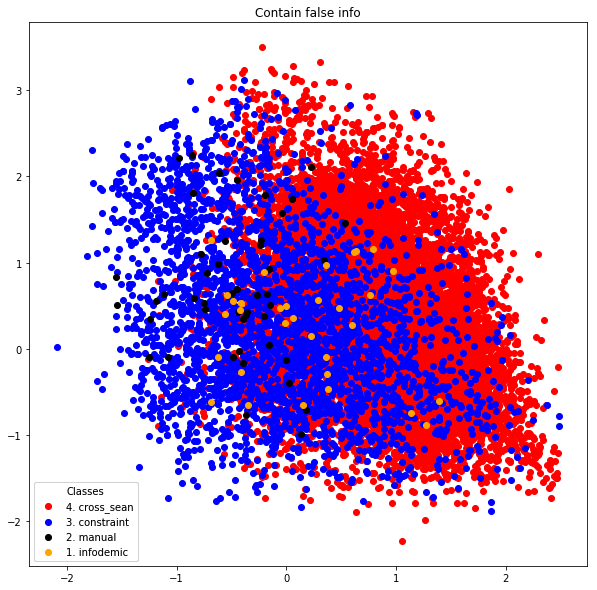

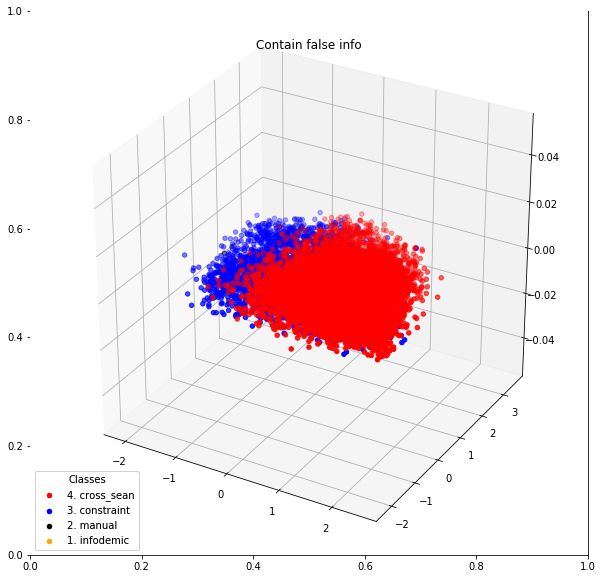

In [173]:
X_reduced = pca_pipeline.fit_transform(X_train)
pca = pca_pipeline.named_steps["pca"]
print("pca.explained_variance_ratio_:", pca.explained_variance_ratio_, "sum:", sum(pca.explained_variance_ratio_))
utils.visualize_2pcs(X_reduced[y_train==1], groups[y_train==1], title="Contain false info")
utils.visualize_3pcs(X_reduced[y_train==1], groups[y_train==1], title="Contain false info")